In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [10]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")

In [3]:
train.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


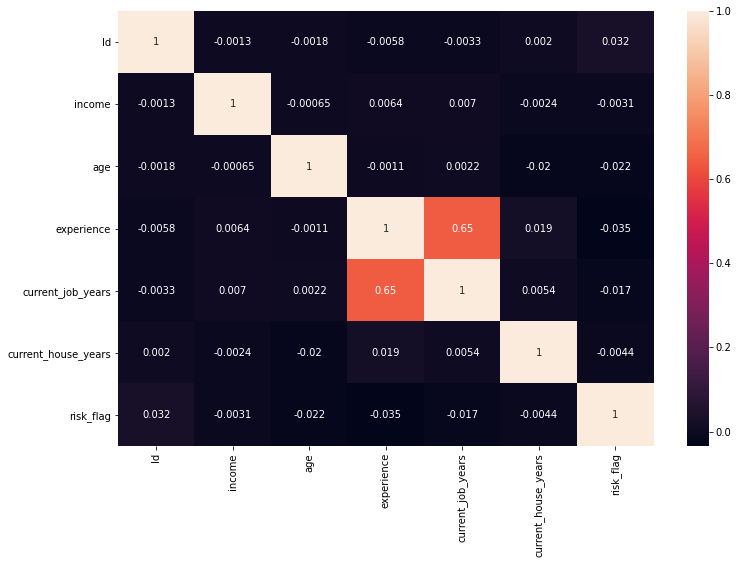

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True)

In [13]:
pip install prince

In [32]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")
test=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Test Data.csv")
test.rename(columns={"id":"Id"},inplace=True)

y=train['risk_flag']
train_no_target=train.drop('risk_flag',axis=1)
loans=pd.concat([train_no_target,test],axis=0)

categorical_cols= loans.select_dtypes(include=["object"]).columns
numerical_cols =  loans.select_dtypes(include=["int64","float64"]).columns

In [41]:
loans

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27996,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10
27996,27997,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14
27997,27998,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13
27998,27999,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14


In [35]:
print(categorical_cols,numerical_cols)

Index(['married', 'house_ownership', 'car_ownership', 'profession', 'city',
       'state'],
      dtype='object') Index(['Id', 'income', 'age', 'experience', 'current_job_years',
       'current_house_years'],
      dtype='object')


In [40]:
print(loans[categorical_cols].columns)
print(train_no_target[categorical_cols].columns)

Index(['married', 'house_ownership', 'car_ownership', 'profession', 'city',
       'state'],
      dtype='object')
Index(['married', 'house_ownership', 'car_ownership', 'profession', 'city',
       'state'],
      dtype='object')


In [45]:
import prince
mca = prince.MCA(n_components=2,random_state=42)
mca_features=mca.fit_transform(loans[categorical_cols])

In [48]:
mca1=mca_features[0]
print()

0         0.052923
1        -0.404483
2         1.099784
3         0.818974
4        -0.317483
            ...   
251995    0.424043
251996    0.179270
251997   -0.438499
251998   -1.843913
251999   -0.229182
Name: 0, Length: 252000, dtype: float64


In [49]:
train_no_target.loc[:,'MCA1'] = mca1[:len(train_no_target)]
test.loc[:,'MCA1']= mca1[len(train_no_target):]

In [37]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2,random_state=202020).fit(loans[numerical_cols])
train_no_target.loc[:,'PCA1']= pca.transform(train_no_target[numerical_cols])[:,0]
test.loc[:,'PCA1']= pca.transform(test[numerical_cols])[:,0]

In [51]:
test

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,PCA1,MCA1
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,2.392737e+06,0.403375
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10,-3.785349e+06,-0.400524
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14,3.900989e+06,-0.456821
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12,-3.055932e+06,-0.361353
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11,-4.986924e+06,0.238537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27996,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10,4.955126e+06,-0.040613
27996,27997,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14,-2.082590e+06,0.078782
27997,27998,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13,3.082060e+06,-0.450572
27998,27999,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14,4.473825e+06,-0.644275


In [57]:
loans=pd.concat([train_no_target,test],axis=0)

In [52]:
def agg_groupby(df,primary_key,operations,agg_cols):
  return df.groupby(primary_key).agg(operations).reset_index().rename(columns=agg_cols)

def left_join(df1,df2,primary_key):
  return df1.merge(df2,how='left',on=primary_key)

def aggregation(df,primary_key,operation,cols):
  for c in cols:
    df=left_join(df,
                 agg_groupby(df,
                             [primary_key],
                             {c:operation},
                             {c:primary_key+"_"+operation+"_"+c}),
                 primary_key)
  return df

In [61]:
loans.columns

Index(['Id', 'income', 'age', 'experience', 'married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_years',
       'current_house_years', 'PCA1', 'MCA1'],
      dtype='object')

In [60]:
aggregation_columns = ['income', 'age', 'experience', 'current_job_years','current_house_years', 'PCA1', 'MCA1']
operation=['mean','median','min','max','std']

In [62]:
for op in operation:
  loans=aggregation(loans,'state',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'city',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'profession',op,aggregation_columns)

In [65]:
loans=aggregation(loans,'profession','nunique',['state'])
loans=aggregation(loans,'profession','nunique',['city'])
loans=aggregation(loans,'married','nunique',['profession'])
loans=aggregation(loans,'house_ownership','nunique',['profession'])

In [66]:
loans.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,PCA1,MCA1,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_MCA1,state_max_income,state_max_age,state_max_experience,state_max_current_job_years,state_max_current_house_years,...,city_std_MCA1,profession_mean_income,profession_mean_age,profession_mean_experience,profession_mean_current_job_years,profession_mean_current_house_years,profession_mean_PCA1,profession_mean_MCA1,profession_median_income,profession_median_age,profession_median_experience,profession_median_current_job_years,profession_median_current_house_years,profession_median_PCA1,profession_median_MCA1,profession_min_income,profession_min_age,profession_min_experience,profession_min_current_job_years,profession_min_current_house_years,profession_min_PCA1,profession_min_MCA1,profession_max_income,profession_max_age,profession_max_experience,profession_max_current_job_years,profession_max_current_house_years,profession_max_PCA1,profession_max_MCA1,profession_std_income,profession_std_age,profession_std_experience,profession_std_current_job_years,profession_std_current_house_years,profession_std_PCA1,profession_std_MCA1,profession_nunique_state,profession_nunique_city,married_nunique_profession,house_ownership_nunique_profession
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,-3.696518e+06,0.052923,4.888681e+06,49.579096,10.543407,6.576406,12.011188,-111681.420776,0.152428,4735088,49.0,11,6,12,-265281.740738,0.151440,13629,21,0,0,10,-4.986741e+06,-0.008804,9994932,79,20,14,14,...,0.061899,5.175032e+06,49.368986,9.526548,5.895726,12.013226,174670.088402,-0.173634,5351331.0,49.0,9.0,5.0,12,350965.678188,-0.209809,37057,21,0,0,10,-4.963314e+06,-1.863815,9990505,79,20,14,14,4.990135e+06,2.341167,2.919954e+06,17.071219,5.957231,3.349963,1.363982,2.919955e+06,0.590916,29,299,74,74
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,2.574163e+06,-0.404483,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.058816,-0.391318,5194149,50.0,10,6,12,193795.485680,-0.396774,10318,21,0,0,10,-4.990037e+06,-0.536496,9987388,79,20,14,14,...,0.061767,4.891296e+06,50.060558,10.074807,6.615278,11.907975,-109065.945465,-0.051495,4994848.0,51.0,10.0,6.0,12,-5511.236377,-0.147773,51528,21,0,0,10,-4.948842e+06,-1.800335,9964816,79,20,14,14,4.964446e+06,2.400573,2.784932e+06,16.189468,5.772401,3.569303,1.336216,2.784932e+06,0.507093,29,299,74,74
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,-1.008538e+06,1.099784,5.153478e+06,50.800439,8.561373,5.919110,12.071014,153116.648819,1.102486,5421502,52.0,8,6,12,421146.475752,1.103102,16212,21,0,0,10,-4.984158e+06,0.951656,9987955,79,20,14,14,...,0.051094,4.922266e+06,50.406352,9.887777,6.238884,11.878345,-78096.280477,-0.102282,4813985.0,51.0,10.0,6.0,12,-186380.876130,-0.175557,11799,21,0,0,10,-4.988570e+06,-1.829151,9980565,79,20,14,14,4.980196e+06,2.345500,2.908484e+06,16.250134,5.538634,3.267220,1.463660,2.908484e+06,0.602923,28,297,74,74
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1.256098e+06,0.818974,4.931571e+06,49.287296,11.217366,6.432401,12.014763,-68790.484963,0.842121,4739803,50.0,12,6,12,-260551.680929,0.846865,13696,21,0,0,10,-4.986658e+06,0.685918,9991569,79,20,14,14,...,0.051888,4.891296e+06,50.060558,10.074807,6.615278,11.907975,-109065.945465,-0.051495,4994848.0,51.0,10.0,6.0,12,-5511.236377,-0.147773,51528,21,0,0,10,-4.948842e+06,-1.800335,9964816,79,20,14,14,4.964446e+06,2.400573,2.784932e+06,16.1

In [67]:
train = loans[:len(train)]
test  = loans[len(train):]
print(train.shape,test.shape)

(252000, 123) (28000, 123)


In [70]:
for cols in categorical_cols:
    train[cols] = train[cols].astype(str)
    test[cols]  = test[cols].astype(str)

cate_features_index = np.where(train.dtypes == object)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
cate_features_index

array([4, 5, 6, 7, 8, 9])

In [76]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train,y)
X_over=pd.DataFrame(X_over,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [77]:
print(X_over.shape,y_over.shape)

(442008, 123) (442008,)


In [78]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_over,y_over,random_state=0,test_size=0.2,shuffle=True)

In [ ]:
pip install catboost 

In [80]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier(n_estimators=2000,random_state=0)
cat.fit(x_train,y_train,cat_features=cate_features_index,eval_set=(x_val,y_val))

Learning rate set to 0.099872
0:	learn: 0.5916807	test: 0.5890930	best: 0.5890930 (0)	total: 662ms	remaining: 22m 2s
1:	learn: 0.5029605	test: 0.4961465	best: 0.4961465 (1)	total: 1.13s	remaining: 18m 49s
2:	learn: 0.4533884	test: 0.4448548	best: 0.4448548 (2)	total: 1.57s	remaining: 17m 28s
3:	learn: 0.4084190	test: 0.3966878	best: 0.3966878 (3)	total: 2.04s	remaining: 16m 58s
4:	learn: 0.3771328	test: 0.3631664	best: 0.3631664 (4)	total: 2.53s	remaining: 16m 50s
5:	learn: 0.3563991	test: 0.3405922	best: 0.3405922 (5)	total: 2.98s	remaining: 16m 29s
6:	learn: 0.3421718	test: 0.3256035	best: 0.3256035 (6)	total: 3.58s	remaining: 16m 58s
7:	learn: 0.3296761	test: 0.3122014	best: 0.3122014 (7)	total: 4.04s	remaining: 16m 44s
8:	learn: 0.3217425	test: 0.3036116	best: 0.3036116 (8)	total: 4.61s	remaining: 16m 59s
9:	learn: 0.3160609	test: 0.2982455	best: 0.2982455 (9)	total: 5.29s	remaining: 17m 33s
10:	learn: 0.3091748	test: 0.2909030	best: 0.2909030 (10)	total: 5.92s	remaining: 17m 50s
1

In [82]:
import pickle
filename = 'model_catboost.sav'
pickle.dump(cat, open(filename, 'wb'))

In [90]:
y_val_pred=cat.predict(x_val)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val_pred,y_val)

0.9926307394159728

In [85]:
predictions=cat.predict(test)
result=pd.DataFrame()
result["id"]=test["Id"]
result["risk_flag"]=predictions

In [86]:
result.risk_flag.value_counts()

0    26187
1     1813
Name: risk_flag, dtype: int64

In [88]:
result.to_csv("predictions_cat_extrafeatures.csv",index=False)

# KNN on extra features 

In [94]:
x_train_knn=pd.get_dummies(data=x_train,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["profession","city","state"],axis=1,inplace=True)

x_val_knn=pd.get_dummies(data=x_val,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_val_knn.drop(["profession","city","state"],axis=1,inplace=True)

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
grid_params={
    'n_neighbors':[3,5,11,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
gs=GridSearchCV(KNeighborsClassifier(),grid_params,verbose=2,cv=3,n_jobs=-1)

gs_results=gs.fit(x_train_knn,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 50.7min finished


In [102]:
y_pred_val=gs_results.predict(x_val_knn)
auc_test = roc_auc_score(y_val, y_pred_val)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.944264


In [104]:
test_knn=pd.get_dummies(data=test,columns=["house_ownership","married","car_ownership"],drop_first=True)
test_knn.drop(["profession","city","state"],axis=1,inplace=True)

In [105]:
test_knn

,Id,income,age,experience,current_job_years,current_house_years,PCA1,MCA1,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_MCA1,state_max_income,state_max_age,state_max_experience,state_max_current_job_years,state_max_current_house_years,state_max_PCA1,state_max_MCA1,state_std_income,state_std_age,state_std_experience,state_std_current_job_years,...,profession_mean_current_job_years,profession_mean_current_house_years,profession_mean_PCA1,profession_mean_MCA1,profession_median_income,profession_median_age,profession_median_experience,profession_median_current_job_years,profession_median_current_house_years,profession_median_PCA1,profession_median_MCA1,profession_min_income,profession_min_age,profession_min_experience,profession_min_current_job_years,profession_min_current_house_years,profession_min_PCA1,profession_min_MCA1,profession_max_income,profession_max_age,profession_max_experience,profession_max_current_job_years,profession_max_current_house_years,profession_max_PCA1,profession_max_MCA1,profession_std_income,profession_std_age,profession_std_experience,profession_std_current_job_years,profession_std_current_house_years,profession_std_PCA1,profession_std_MCA1,profession_nunique_state,profession_nunique_city,married_nunique_profession,house_ownership_nunique_profession,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
252000,1,7393090,59,19,4,13,2.392737e+06,0.403375,5.154826e+06,50.106440,9.958349,6.293482,11.956421,154472.264604,0.310460,5275803,50.0,10,6,12,275449.100451,0.313279,10310,21,0,0,10,-4.990045e+06,0.132405,9959440,79,20,14,14,4.959086e+06,0.489150,2.870628e+06,17.068112,6.068396,3.597928,...,5.828527,12.127927,-136603.040818,0.175076,4859415.0,52.0,9.0,5.0,12,-140949.811345,0.102389,34955,21,0,0,10,-4.965414e+06,-1.692293,9991298,79,20,14,14,4.990929e+06,2.459928,2.930773e+06,16.609660,6.203325,3.561203,1.302373,2.930773e+06,0.522543,35,311,74,74,0,1,1,0
252001,2,1215004,25,5,5,10,-3.785349e+06,-0.400524,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.058816,-0.391318,5194149,50.0,10,6,12,193795.485680,-0.396774,10318,21,0,0,10,-4.990037e+06,-0.536496,9987388,79,20,14,14,4.987019e+06,-0.185659,2.908268e+06,17.043653,5.887652,3.547086,...,6.405668,11.958581,41316.200778,-0.025064,5453088.0,49.0,12.0,6.0,12,452730.227843,-0.143015,29380,21,0,0,10,-4.970990e+06,-1.791185,9980725,79,20,14,14,4.980355e+06,2.361035,2.771686e+06,16.928635,6.056248,3.702371,1.441172,2.771686e+06,0.521890,34,297,74,74,0,1,1,0
252002,3,8901342,50,12,9,14,3.900989e+06,-0.456821,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.058816,-0.391318,5194149,50.0,10,6,12,193795.485680,-0.396774,10318,21,0,0,10,-4.990037e+06,-0.536496,9987388,79,20,14,14,4.987019e+06,-0.185659,2.908268e+06,17.043653,5.887652,3.547086,...,6.285098,11.914227,158748.951395,-0.138325,5173267.0,50.0,10.0,5.0,12,172911.522918,-0.173722,28993,21,0,0,10,-4.971378e+06,-1.860260,9976302,79,20,14,14,4.975933e+06,2.333489,3.131100e+06,16.688904,5.916230,3.661169,1.380752,3.131100e+06,0.587349,35,307,74,74,0,1,1,0
252003,4,1944421,49,9,3,12,-3.055932e+06,-0.361353,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.058816,-0.391318,5194149,50.0,10,6,12,193795.485680,-0.396774,10318,21,0,0,10,-4.990037e+06,-0.536496,9987388,79,20,14,14,4.987019e+06,-0.185659,2.908268e+06,17.043653,5.887652,3.547086,...,6.505683,11.996532,-110922.214347,-0.036332,5074140.0,46.0,11.0,6.0,12,73773.950697,-0.122791,11550,21,0,0,10,-4.988821e+06,-1.811197,9993798,79,20,14,14,4.993429e+06,2.354500,2.792723e+06,17.949103,6.051475,3.849570,1.383215,2.792723e+

In [109]:
pred_knn=gs_results.predict(test_knn)

In [110]:
result_knn=pd.DataFrame()
result_knn["id"]=test_knn["Id"]
result_knn["risk_flag"]=pred_knn

In [112]:
result_knn.to_csv("pred_knn_extraFeatures.csv",index=False)

# Extra

In [ ]:
X = train.drop('risk_flag', axis=1)
y = train['risk_flag']

In [ ]:
numeric=X.select_dtypes(include=["int64","float64"]).columns

In [ ]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,mutual_info_classif
# generate dataset
# define feature selection
fs = SelectKBest(score_func=f_classif, k="all")
# apply feature selection
X_selected = fs.fit_transform(X, y)
bestfeatures=pd.DataFrame()
bestfeatures["col_name"]=X.columns
bestfeatures["scores"]=fs.scores_
bestfeatures.sort_values(by="scores")

,col_name,scores
0,income,2.407945
4,current_house_years,4.823851
3,current_job_years,72.348526
7,married_single,112.153048
1,age,119.918389
5,house_ownership_owned,139.229273
8,car_ownership_yes,145.666154
6,house_ownership_rented,179.063593
2,experience,300.692307


In [ ]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X, y)
X_train_fs = fs.transform(X)
bestfeatures=pd.DataFrame()
bestfeatures["col_name"]=X.columns
bestfeatures["scores"]=fs.scores_
bestfeatures.sort_values(by="scores")

,col_name,scores
5,house_ownership_owned,0.000650
1,age,0.002600
2,experience,0.003599
3,current_job_years,0.004589
8,car_ownership_yes,0.004849
4,current_house_years,0.006877
7,married_single,0.038446
6,house_ownership_rented,0.040189
0,income,0.159839


In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X,y)
X_over=pd.DataFrame(X_over,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
transforms = list()
transforms.append(('mms', MinMaxScaler()))
# transforms.append(('ss', StandardScaler()))
# transforms.append(('rs', RobustScaler()))
transforms.append(('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')))
transforms.append(('kbd', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')))
transforms.append(('pca', PCA(n_components=7)))
transforms.append(('svd', TruncatedSVD(n_components=7)))
# create the feature union
fu = FeatureUnion(transforms)

In [ ]:
X_new=fu.fit_transform(X_over)

In [ ]:
print(X_new.shape,y_over.shape)

(442008, 41) (442008,)


In [ ]:
gbc=GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(gbc, X_new, y_over, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Roc Auc:",np.mean(scores))

Roc Auc: 0.6906649829474686


In [ ]:
# define the feature selection
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=15)
# define the model
model = LogisticRegression(solver='liblinear')
# define the pipeline
steps = list()
steps.append(('fu', fu))
steps.append(('rfe', rfe))
steps.append(('m', model))
pipeline = Pipeline(steps=steps)
# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_over, y_over, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), std(scores)))

Accuracy: 0.545 (0.023)


AttributeError: ignored

In [ ]:
def list_unique_values(data,columns,plot=False):
  for c in columns:
    print("Unique value of:",c)
    print(data[c].value_counts())
    print("==============================================")

In [ ]:
list_unique_values(data=train,columns=train.select_dtypes(exclude=['int64','float64']).columns,plot=True)

Unique value of: married
single     226272
married     25728
Name: married, dtype: int64
Unique value of: house_ownership
rented          231898
owned            12918
norent_noown      7184
Name: house_ownership, dtype: int64
Unique value of: car_ownership
no     176000
yes     76000
Name: car_ownership, dtype: int64
Unique value of: profession
Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
Drafter                       5359
Magistrate                    5357
Fashion_Designer              5304
Air_traffic_controller        5281
Comedian                      5259
Industrial_Engineer           5250
Mechanical_engineer           5217
Chemical_engineer             5205
Technical_writer              5195
Hotel_Manager                 5178
Financial_Analyst             5167
Graphic_Designer              5166
Flight_attendant              5128
Biomedical_Engineer   

In [ ]:
def create_risky_state_col(data=train,percent_cut=20):
  number_of_risky_loans_per_state=train[train["risk_flag"]==1].groupby("state")["risk_flag"].count().sort_values()
  number_of_safe_loans_per_state=train[train["risk_flag"]==0].groupby("state")["risk_flag"].count().sort_values()
  total_loans_per_state=(number_of_safe_loans_per_state+number_of_risky_loans_per_state).sort_values()
  percentage_risky_loans_per_state=((number_of_risky_loans_per_state/total_loans_per_state)*100).sort_values()
  risky_states=percentage_risky_loans_per_state[percentage_risky_loans_per_state>=percent_cut].index.values
  train["risky_state"]=train["state"].apply(lambda x: 1 if x in risky_states else 0)
  return data

In [ ]:
train=create_risky_state_col(train,15)

In [ ]:
train[train["risk_flag"]==1].groupby("risky_state")["risk_flag"].count().sort_values()

risky_state
1     3752
0    27244
Name: risk_flag, dtype: int64

In [ ]:
train.head(20)

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag,risky_state
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,1
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,1
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,0
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,0
5,6,6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0,0
6,7,3954973,58,14,married,rented,no,Librarian,Tiruppur,Tamil_Nadu,8,12,0,0
7,8,1706172,33,2,single,rented,no,Economist,Jamnagar,Gujarat,2,14,0,0
8,9,7566849,24,17,single,rented,yes,Flight_attendant,Kota[6],Rajasthan,11,11,0,0
9,10,8964846,23,12,single,rented,no,Architect,Karimnagar,Telangana,5,13,0,0


In [ ]:
def preprocessing(df):
  #train["state"]=train["state"].apply(lambda s:"Uttar_Pradesh" if s=="Uttar_Pradesh[5]" else s)
  #train["age_brackets"]=pd.qcut(train["age"],q=[0,0.4,0.8,1],precision=0,)
  #train["income_brackets"]=pd.qcut(train["income"],q=[0,0.4,0.8,1],precision=0)
  #df=pd.get_dummies(data=df,columns=["age_brackets","income_brackets"],drop_first=True,)
  df=pd.get_dummies(data=df,columns=["house_ownership","married","car_ownership"],drop_first=True)
  df.drop(["Id","profession","city","state"],axis=1,inplace=True)
  #df.drop(["age","income"],axis=1,inplace=True)
  #df.rename(columns = {'age_brackets_(44.0, 68.0]':'age_44to68', 'age_brackets_(68.0, 79.0]':'age_68to79',
   #    'income_brackets_(3983449.0, 7957694.0]':'income_low',
    #   'income_brackets_(7957694.0, 9999938.0]':'income_high'}, inplace = True)
  return df

In [ ]:
train=preprocessing(train)

In [ ]:
train.columns

Index(['income', 'age', 'experience', 'current_job_years',
       'current_house_years', 'risk_flag', 'risky_state',
       'house_ownership_owned', 'house_ownership_rented', 'married_single',
       'car_ownership_yes'],
      dtype='object')

In [ ]:
X = train.drop('risk_flag', axis=1)
y = train['risk_flag']

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X,y)
X_over=pd.DataFrame(X_over,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Oversampling with train test split

In [ ]:
def create_train_test_split_with_sampling(X,y,oversample=False,test_size=0.2):
  if oversample:
    from imblearn.over_sampling import RandomOverSampler
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True)
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    X_over=pd.DataFrame(X_over,columns=X.columns)
    return X_over, X_test, y_over,y_test
  else:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test=create_Xy(X,y,oversample=True,test_size=0.1)
print(X_train.shape,X_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(397964, 9) (25200, 9)


# Testing various models with Stratified K fold ( k=10)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
classifiers = [
    KNeighborsClassifier(3),
    #DecisionTreeClassifier(),
    RandomForestClassifier(),
    #AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', classifier)])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipe, X_over, y_over, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(classifier)
    print('Roc Auc: %.3f' % score)

    # pipe.fit(X_train,y_train)
    # y_pred_test=pipe.predict(X_test)
    # auc_test = roc_auc_score(y_test, y_pred_test)
    # print('ROC AUC test: %f' % auc_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Roc Auc: 0.944
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Roc Auc: 0.974
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
              

# test

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Test Data.csv")
ID=test["id"]

In [ ]:
test["age_brackets"]=pd.qcut(test["age"],q=[0,0.4,0.8,1],precision=0)
test["income_brackets"]=pd.qcut(test["income"],q=[0,0.4,0.8,1],precision=0)
test.drop(["id","profession","city","state","age","income"],axis=1,inplace=True)

In [ ]:
test.drop(["id","profession","city","state"],axis=1,inplace=True)

In [ ]:
display(X_over.head(),test.head())

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years
0,1303835,23,3,single,rented,no,3,13
1,7574516,40,10,single,rented,no,9,13
2,3991815,66,4,married,rented,no,4,10
3,6256451,41,2,single,rented,yes,2,12
4,5768871,47,11,single,rented,no,3,14


,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years
0,7393090,59,19,single,rented,no,4,13
1,1215004,25,5,single,rented,no,5,10
2,8901342,50,12,single,rented,no,9,14
3,1944421,49,9,married,rented,yes,3,12
4,13429,25,18,single,rented,yes,13,11


# Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[50,100]
    }

clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(x_train,y_over)

# Prediction dataframe

In [ ]:
predictions=classifier.predict(x_test)

In [ ]:
result=pd.DataFrame()
result["id"]=ID
result["risk_flag"]=predictions

In [ ]:
result.risk_flag.value_counts()

0    16124
1    11876
Name: risk_flag, dtype: int64

In [ ]:
result.to_csv("prediction.csv",index=False)

# Xgb classifier

In [ ]:
pip install xgboost

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")

In [ ]:
print(X_new.shape,y_over.shape)

(442008, 41) (442008,)


In [ ]:
# train=preprocessing(train)
# X = train.drop('risk_flag', axis=1)
# y = train['risk_flag']

X_train, X_test, y_train, y_test=create_train_test_split_with_sampling(X_new,y,test_size=0.09,oversample=True)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def model_assess(model, name='Default'):
  model.fit(X_new, y_over)
  preds = model.predict(X_test)
  preds_proba = model.predict_proba(X_test)
  print('                   ', name, '\n',classification_report(y_test, model.predict(X_test)))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
model_assess(gbc, 'gradientboosting')

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred=gbc.predict(X_test)
roc_auc_score(y_pred,y_test)

0.5274326159354349

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[50,100]
    }

clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train,y_train)

In [ ]:
X_new.shape

(442008, 41)

In [ ]:
import pandas as pd 
import numpy as np 

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv')
#test=pd.read_csv('')

In [ ]:
def preprocessing(df):
  df=pd.get_dummies(data=df,columns=["house_ownership","married","car_ownership"],drop_first=True)
  df.drop(["profession","city","state"],axis=1,inplace=True)
  return df

In [ ]:
train=preprocessing(train)

X = train.drop('risk_flag', axis=1)
y = train['risk_flag']

from imblearn.under_sampling import NeighbourhoodCleaningRule
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
# transform the dataset
X_under, y_under = undersample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print(X_under.shape,y_under.shape)

(188433, 10) (188433,)


In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.1,shuffle=True)
X_train_new=fu.fit_transform(X_under)
#X_test_new=fu.transform(X_test)
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
# gbc=GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(gbc, X_train_new, y_under, scoring='roc_auc', cv=cv, n_jobs=-1)
# print("Roc Auc:",np.mean(scores))

In [ ]:
# gbc=GradientBoostingClassifier()
# gbc.fit(X_train_new,y_under)
y_pred_test=gbc.predict(X_train_new)
auc_test = roc_auc_score(y_under, y_pred_test)
print('ROC AUC test: %f' % auc_test)

AttributeError: ignored

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Test Data.csv")
ID=test["id"]
test=preprocessing(test)
test=fu.transform(test)

In [ ]:
test.shape

(28000, 44)

In [ ]:
predictions=gbc.predict(test)

In [ ]:
result=pd.DataFrame()
result["id"]=ID
result["risk_flag"]=predictions

In [ ]:
result["risk_flag"].value_counts()

0    27959
1       41
Name: risk_flag, dtype: int64

In [ ]:
train["risk_flag"].value_counts()

0    221004
1     30996
Name: risk_flag, dtype: int64

In [ ]:
30996/221004

0.1402508551881414

In [ ]:
result.to_csv("prediction1.csv",index=False)